<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_dl1_dogsvscats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
!pip3 install torchtext==0.2.3

In [0]:
!pip3 install torch==0.4.1

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
!wget http://files.fast.ai/data/dogscats.zip
!unzip dogscats.zip
!mkdir data
!mv dogscats data

--2019-01-03 13:37:29--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  15.8MB/s    in 54s     

2019-01-03 13:38:24 (15.2 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]

Archive:  dogscats.zip
   creating: dogscats/
   creating: dogscats/sample/
   creating: dogscats/sample/train/
   creating: dogscats/sample/train/cats/
  inflating: dogscats/sample/train/cats/cat.2921.jpg  
  inflating: dogscats/sample/train/cats/cat.394.jpg  
  inflating: dogscats/sample/train/cats/cat.4865.jpg  
  inflating: dogscats/sample/train/cats/cat.3570.jpg  
  inflating: dogscats/sample/train/cats/cat.2266.jpg  
  inflating: dogscats/sample/train/cats/cat.9021.jpg  
  inflating: dogscats/sample/train/cats/cat.1

In [0]:
PATH = "data/dogscats/"
sz=224

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))

In [5]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 91644210.40it/s]


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.040393   0.026595   0.9925    
    1      0.04767    0.026208   0.991     
    2      0.038428   0.026178   0.9895    



[array([0.02618]), 0.9895]

In [6]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
data.classes

['cats', 'dogs']

In [0]:
log_preds = learn.predict()

In [9]:
log_preds[:10]

array([[ -0.00058,  -7.45605],
       [ -0.00003, -10.36025],
       [ -0.03917,  -3.25933],
       [ -0.00086,  -7.05411],
       [ -0.00023,  -8.36372],
       [ -0.00007,  -9.63289],
       [ -0.00013,  -8.91787],
       [ -0.00009,  -9.31572],
       [ -0.00407,  -5.50688],
       [ -0.00001, -11.80914]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1]) 

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


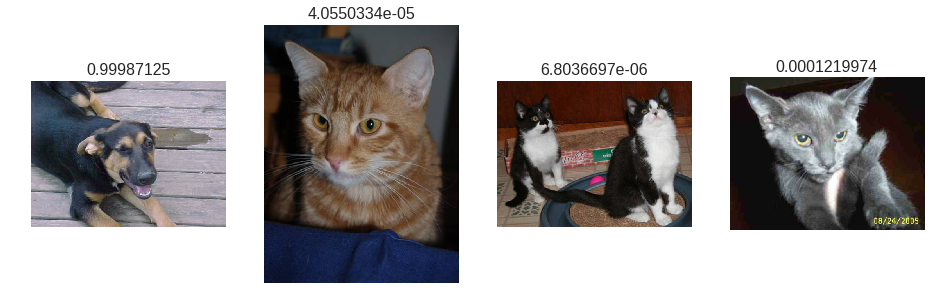

In [14]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


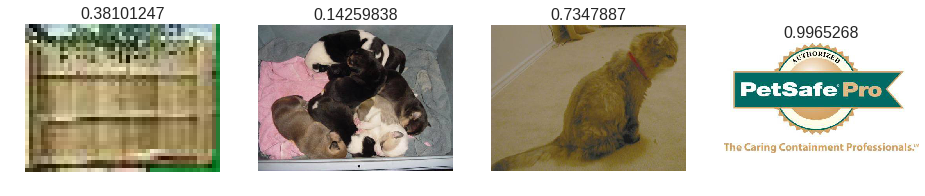

In [15]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


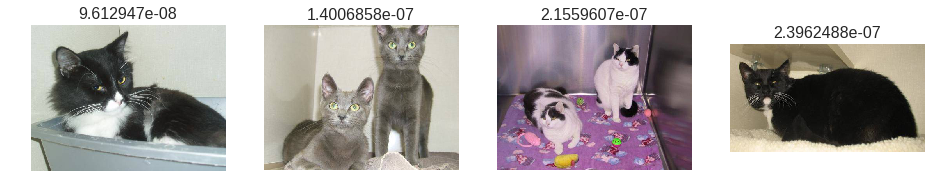

In [17]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


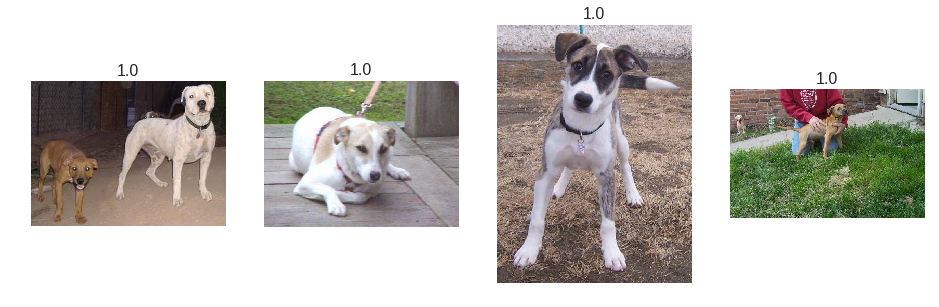

In [18]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


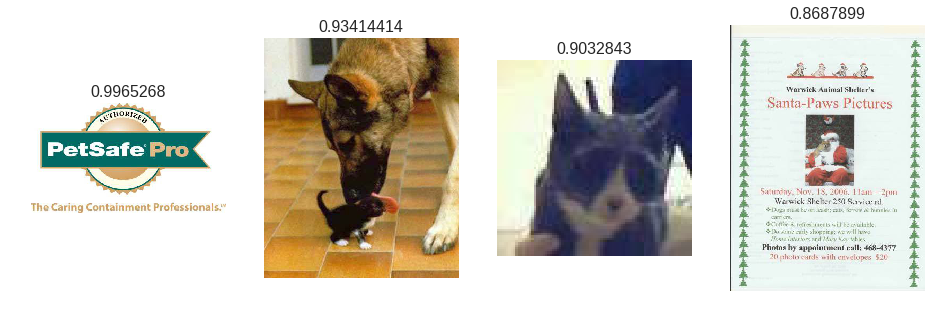

In [19]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


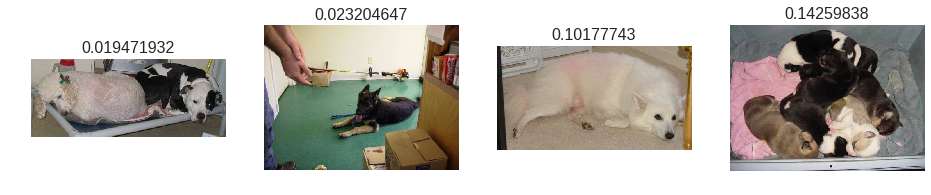

In [20]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


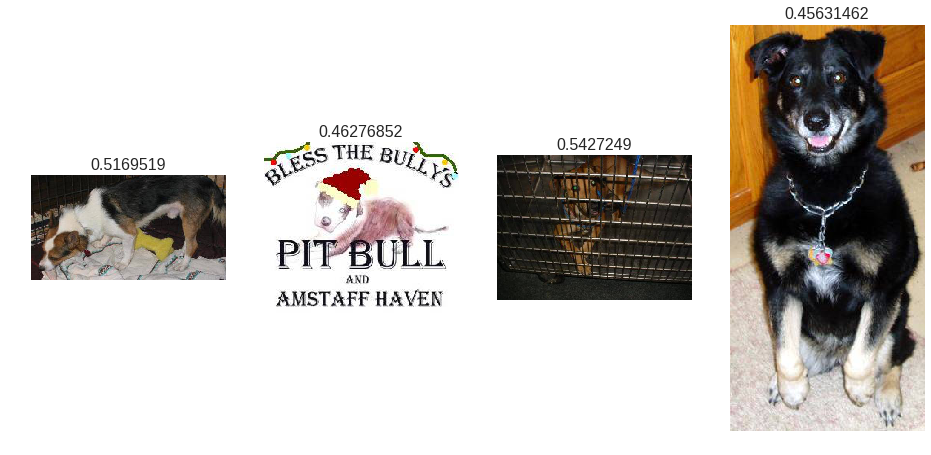

In [21]:

most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [0]:
sz=224
arch=vgg16
bs=64

In [0]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [0]:
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms_from_model(arch, sz))

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:06<00:00, 91091894.19it/s]


100%|██████████| 32/32 [00:28<00:00,  1.57it/s]


In [26]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.062582   0.02912    0.99      
    1      0.04861    0.030489   0.988     
    2      0.055001   0.026767   0.9875    



[array([0.02677]), 0.9875]

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.062367   0.029038   0.9905    
    1      0.048818   0.027275   0.9905    



[array([0.02728]), 0.9905]

In [0]:
learn.precompute=False

In [31]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.049169   0.024301   0.991     



[array([0.0243]), 0.991]

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [34]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.057958   0.029638   0.989     



[array([0.02964]), 0.989]

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

 12%|█▎        | 45/360 [02:35<18:01,  3.43s/it, loss=0.0214]

In [36]:
learn.fit(lr, 3, cycle_len=3)

epoch      trn_loss   val_loss   accuracy   
    0      0.02831    0.016338   0.9935    
    1      0.02275    0.012069   0.995     
    2      0.021955   0.013152   0.995     
    3      0.022362   0.017379   0.994     
    4      0.014874   0.012895   0.996     
    5      0.016793   0.014103   0.995     
    6      0.022266   0.012607   0.996     
    7      0.019871   0.016063   0.9935    
    8      0.019096   0.01538    0.9935    



[array([0.01538]), 0.9935]

In [37]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)